## Churn Problem

##### Introduction

---


The purpose of this notebook is to design a model which tells us for a given dataset whether a customer has churned or not. The definition is to be valid for all kinds of non-contractual servies whether it be fashion retail, electronics retail, etc. 
Also, for this purpose the given notebook will also define the number of months from the last transaction date , after which we can tell if a person has churned or not.

##### Challenges

---

1) Defining the time period after which a customer can be said to have churned is in itself a great challenge. Since, in this regard churn has to be a duration which is both useful and meaningful for the company to which we are selling the model to. Like coming out with a churn figure of say more than a year , is pretty useless.

There are various features one can use to define churn: 1) like using the various transaction dates, 






### **Importing libraries & loading the required data **



>  First of all we import the necessary packages into our notebook.







In [0]:
#Importing necessary packages.
%matplotlib inline 
import pandas as pd #Data Manipulation package
import numpy as np #Linear Algebra package
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn gives us better aesthetics than basic matplotlib in our plots.
from sklearn.preprocessing import Imputer # Imputation package of scikit-learn.

In [0]:
"""!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive"""

'!apt-get install -y -qq software-properties-common python-software-properties module-init-tools\n!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null\n!apt-get update -qq 2>&1 > /dev/null\n!apt-get -y install -qq google-drive-ocamlfuse fuse\nfrom google.colab import auth\nauth.authenticate_user()\nfrom oauth2client.client import GoogleCredentials\ncreds = GoogleCredentials.get_application_default()\nimport getpass\n!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL\nvcode = getpass.getpass()\n!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}\n\n!mkdir -p drive\n!google-drive-ocamlfuse drive'

In [0]:
# Changing the directory
"""import os
os.chdir("drive/ML")"""
!pwd

/content/drive/ML


In [0]:
!ls /content

datalab  drive


There are two files for us to consider on which we have to define churn & train and test our model.
sales.csv contains the sales data, whereas cap_reg contains the customer personal details & details relating to loyalty points & other schemes.

#### For reading the two files we are using the pandas library, and we require the encoding parameter in sales.csv. And the dtype & encoding parameter for cap_reg  

Encoding is required for pandas to read the obscure characters from other languages such as Arabic, as is the case here. For other regions encoding has to be supplied in the same manner.
Link to standard python encodings is given below:
[List of Standard Python encodings.](https://docs.python.org/3/library/codecs.html#standard-encodings)

Dtype is the type of the columns which can be float64, int , str ,etc but , when a column contains more than one type of values say both string and int , then in such cases of mixed values object is used. Giving the dtype=object value makes all the columns dtype=object


In [0]:
#Reading the data
sales = pd.read_csv("sales.csv", encoding= "ISO-8859-1")
cap_reg = pd.read_csv("cap_reg.csv", encoding="ISO-8859-1", dtype=object)

In [0]:
sales.head()

,Unnamed: 0,custaccount,transdate,store,itemid,receiptid,sales,subclass,class,section,subdepartment,department
0,1,BKSA-CUS-293713,2017-04-11 00:00:00.0,SW01,1040000077702,SW010310103694,32.0,L - Youth Ladies - Short Dress,Youth Ladies - Dress,Youth Ladies,Ladies Apparel,Ladies
1,2,BKSA-CUS-102014,2016-08-21 00:00:00.0,SC01,1100000007681,SC010510044367,25.0,H - Home Decor - Wall Arts - Photo frames,Wall Arts,Home Decor,Home - Decor,Home
2,3,BKSA-CUS-039803,2016-02-25 00:00:00.0,SC03,1070000004744,SC030110048022,11.0,M - Formal Man - L/S Shirt,Formal Man - Shirts,Formal Man,Mens Apparel,Men
3,4,BKSA-CUS-274625,2017-03-24 00:00:00.0,SE03,1040000084264,SE030510001941,47.0,L - Smart Ladies - Maxi Dress,Smart Ladies - Dress,Smart Ladies,Ladies Apparel,Ladies
4,5,BKSA-CUS-350359,2017-06-19 00:00:00.0,SW05,1050000003244,SW050510006435,21.0,Ladies Bracelets,Ladies Bracelet,Ladies Jewelry,Womens Accessories,Accessories


In [0]:
#No. of instances
len(sales) 

4482406

The below tuple shows that there are customers with only negative transactions also. This will occur in rare cases, 
#### This type of case pops up maybe, since the customer didn't give his phone number when he bought the item, but gave his phone number on return. Such people won't have customerid when they are buying items.

In [0]:
sales['custaccount'].nunique(), sales.loc[sales['sales']> 0, 'custaccount'].nunique()

(492599, 492545)

#### For this model to work there should be a transdate column, named as transdate
Changing transdate column to datetime format

In [0]:
sales['transdate'] = pd.to_datetime(sales['transdate'], yearfirst=True, errors='coerce')

### Each receiptid can have multiple rows, since in 1 transaction there can be multiple items purchased.

 Note 1 receiptid can have several rows, since a transaction with several different items is listed in different rows.
Below, we can see multiple items purchased by a single customer in a single receipt id. As can be seen receiptid ending with 392 has 7 items in one single transaction

In [0]:
sales.sort_values('receiptid') #Not inplace. just sorting here for displaying information.

,Unnamed: 0,custaccount,transdate,store,itemid,receiptid,sales,subclass,class,section,subdepartment,department
3403077,3403078,BKSA-CUS-047637,2016-10-16,EX02,1010000016046,EX020110010392,5.0,K - Newborn Girls - LS Polo Neck,Newborn Girls - T shirt,Newborn Girls,Kids Apparel - Girls,Kids
1469411,1469412,BKSA-CUS-047637,2016-10-16,EX02,1010000011243,EX020110010392,11.0,K - Infant Girls - Tunics,Infant Girls - Tops,Infant Girls,Kids Apparel - Girls,Kids
545180,545181,BKSA-CUS-047637,2016-10-16,EX02,1010000011360,EX020110010392,8.0,K - Infant Girls - Dress,Infant Girls - Dress,Infant Girls,Kids Apparel - Girls,Kids
2718075,2718076,BKSA-CUS-047637,2016-10-16,EX02,1010000011486,EX020110010392,16.0,K - Infant Girls - Dress,Infant Girls - Dress,Infant Girls,Kids Apparel - Girls,Kids
1692134,1692135,BKSA-CUS-047637,2016-10-16,EX02,1010000011362,EX020110010392,8.0,K - Infant Girls - Dress,Infant Girls - Dress,Infant Girls,Kids Apparel - Girls,Kids
3021753,3021754,BKSA-CUS-047637,2016-10-16,EX02,1010000011233,EX020110010392,11.0,K - Infant Girls - Tunics,Infant Girls - Tops,Infant Girls,Kids Apparel - Girls,Kids
1953453,1953454,BKSA-CUS-047637,2016-10-16,EX02,1010000016034,EX020110010392,5.0,K - Newborn Girls - LS Crew Neck,Newborn Girls - T shirt,Newborn Girls,Kids Apparel - Girls,Kids
3123915,3123916,BKSA-CUS-277529,2017-03-27,EX02,1010000034837,EX020110016239,11.0,K - Newborn Girls - Romper,Newborn Girls - Romper,Newborn Girls,Kids Apparel - Girls,Kids
3606262,3606263,BKSA-CUS-277529,2017-03-27,EX02,1010000034813,EX020110016239,15.0,K - Newborn Girls - Sleepsuit,Newborn Girls - Sleepsuit,Newborn Girls,Kids Apparel - Girls,Kids
513693,513694,BKSA-CUS-277529,2017-03-27,EX02,1010000013784,EX020110016239,5.0,K - Unisex - Blanket,Unisex - Blanket,Unisex,Kids - Unisex,Kids


#### Creating a new dataframe df, with only buys/no-replacements, and columns : custaccount & transdate.

### Here, I am aiming on defining churn i.e, no. of months after which , if a customer doesn't make a transaction, we can say that he has churned or we have lost that customer. So for defining churn I am using the interpurchase times between the different transaction dates and then plotting a cumulative plot.

In [0]:
df = (sales[sales['sales'] > 0][['custaccount', 'transdate']])

In [0]:
len(df)

4292958

### Deleting rows with same custaccount and transdate, so that duplicates get dropped

 Removing duplicates due to multiple items purchased in one transaction, and sorting by custaccount & transdate, so , as to get transdates in ascending order grouped by custaccount.

In [0]:
df = df.sort_values(by = ['custaccount', 'transdate']).drop_duplicates()

In [0]:
len(df['custaccount'].unique())

492545

#### Sorted by custaccounts and their different transaction dates by ascending order.

In [0]:
df.head(20) 

,custaccount,transdate
457876,BKSA-CUS-000064,2014-12-07
1054625,BKSA-CUS-000248,2015-02-02
2110130,BKSA-CUS-000300,2016-02-03
152645,BKSA-CUS-000300,2016-03-15
1552293,BKSA-CUS-000300,2016-03-20
536148,BKSA-CUS-000300,2016-04-22
1466609,BKSA-CUS-000300,2016-04-27
734826,BKSA-CUS-000300,2016-05-25
657659,BKSA-CUS-000300,2016-05-31
512222,BKSA-CUS-000300,2016-07-21


#### Grouping by custaccount and taking the different transactions differences.
#### NaT for the customers who had made only single transactions, since groupby diff doesn't work for them, since after groupby they are left with single row & don't have a previous row.
pandas.DataFrame.diff : Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is the element in the same column of the previous row). - From documentation




In [0]:
df['diff'] =  df.groupby('custaccount')['transdate'].diff()

In [0]:
df.head(20)

,custaccount,transdate,diff
457876,BKSA-CUS-000064,2014-12-07,NaT
1054625,BKSA-CUS-000248,2015-02-02,NaT
2110130,BKSA-CUS-000300,2016-02-03,NaT
152645,BKSA-CUS-000300,2016-03-15,41 days
1552293,BKSA-CUS-000300,2016-03-20,5 days
536148,BKSA-CUS-000300,2016-04-22,33 days
1466609,BKSA-CUS-000300,2016-04-27,5 days
734826,BKSA-CUS-000300,2016-05-25,28 days
657659,BKSA-CUS-000300,2016-05-31,6 days
512222,BKSA-CUS-000300,2016-07-21,51 days


#### Dropping customers with single transactions by dropping the rows with NaT 
For datetime64[ns] types, NaT represents missing values. This is a pseudo-native sentinel value that can be represented by NumPy in a singular dtype (datetime64[ns]). pandas objects provide intercompatibility between NaT and NaN. - From Documentation (Pandas)

Also dropping transdate column as it isn't required now.

---



In [0]:
df= df.dropna(how='any').drop('transdate',axis=1)

In [0]:
df.head(20)

,custaccount,diff
152645,BKSA-CUS-000300,41 days
1552293,BKSA-CUS-000300,5 days
536148,BKSA-CUS-000300,33 days
1466609,BKSA-CUS-000300,5 days
734826,BKSA-CUS-000300,28 days
657659,BKSA-CUS-000300,6 days
512222,BKSA-CUS-000300,51 days
2490003,BKSA-CUS-000300,6 days
4313369,BKSA-CUS-000300,42 days
435653,BKSA-CUS-000306,274 days


Setting index as custaccount

In [0]:
df.set_index('custaccount', inplace=True)

In [0]:
df.head()

,diff
custaccount,
BKSA-CUS-000300,41
BKSA-CUS-000300,5
BKSA-CUS-000300,33
BKSA-CUS-000300,5
BKSA-CUS-000300,28


#### Converting the timedelta values to integer by dividing by a single day timedelta and then using astype to convert to 'int' dtype.

In [0]:
df = (df/np.timedelta64(1, 'D')).astype('int')

In [0]:
df.head()

,diff
custaccount,
BKSA-CUS-000300,41
BKSA-CUS-000300,5
BKSA-CUS-000300,33
BKSA-CUS-000300,5
BKSA-CUS-000300,28


#### pandas.DataFrame.values : Return a Numpy representation of the DataFrame. - From documentation

In [0]:
df.values

array([[41],
       [ 5],
       [33],
       ...,
       [ 3],
       [ 3],
       [ 1]])

In [0]:
# Number of bins
num_bin = df.max().values

**Using np.histogram to get the frequencies of the different interpurchase time like [1, 3, 5], which would represent 0 days - 1 interpurchase time, 1 days - 3 interpurchase time, 2 days - 5 interpurchase times, etc. and then taking the cumulative sum of the values numpy arrays thus, generated and then plotting the cumulative graph.**

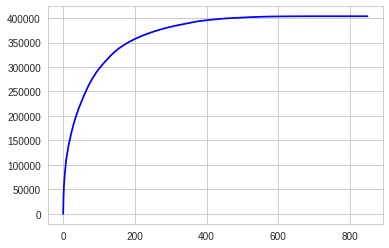

In [0]:
values, base = np.histogram(df.values, bins=np.arange(num_bin))
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

plt.show()

#### Normally we would take the churn period to be the number of days at which the slope is almost zero (gradient), but here as we can see the slope becomes zero after 400 days and defining churn duration as more than a year's time is redundant. On examination of the graph in this case we can see it looks like pareto cdf plot and thus, we can apply the pareto 80:20 rule, which says that 80% of the wealth of the people is distributed between 20% of the population.

Another approach would be to use boxplots and to exclude the outliers, as I've described latter.
![alt text](https://www.safaribooksonline.com/library/view/think-stats/9781449308117/httpatomoreillycomsourceoreillyimages863940.png)

#### churn_days defined by using the 80:20 rule

In [0]:
# Use of Pareto 80:20 rule to solve for churn_days, boxplots could also have been used to remove outliers using concept of interquartile range
churn_days = (((cumulative[::-1].cumsum()/cumulative.sum()) * 100) >= 80).sum()

In [0]:
churn_days

222

#### Using boxplots the values beyond 75 % percentile + 1.5 * IQR are outliers and can be removed. Similarly, points beyond 25% percentile - 1.5 * IQR are counted as outliers and can be removed.
We could have taken the value of iq75 (75 percentile) + 1.5 * IQR as the churn period.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


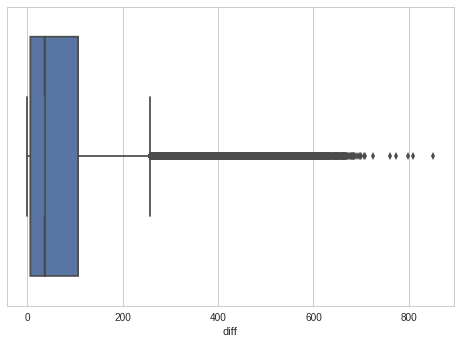

In [0]:
sns.set(style="whitegrid")
_ = sns.boxplot(x = df['diff'], notch=True, whis=1.5)


# Points outside the vertical line that is the whisker are outliers , whis=1.5 , also default parameter.

In [0]:
# Outlier removal using concept of interquartile range.
#iq75, iq25 = np.percentile(df['diff'], [75, 25])
#iqr = iq75 - iq25

In [0]:
# Days of churn calculated using interquartile range concept
#iq75 + iqr * 1.5                               

#### Violin plot to show the same concept of outliers and the density where the most points are situated/located.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


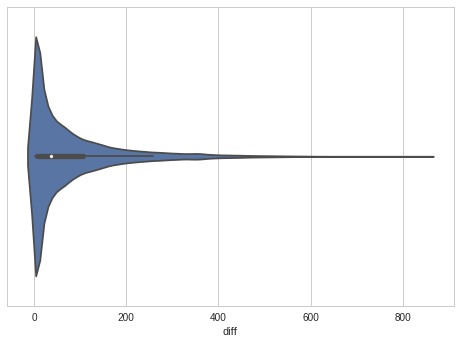

In [0]:
ax = sns.violinplot(df['diff'], scale="count", inner="box")

### Now converting the number of days after which a customer churns into months, respectively.

#### If days are more than or equal to 15 then convert to 1 month, if less than 15 then floor to 0. Using lambda function and numpy.ceil & numpy.floor.

In [0]:
# This is the months function to be used as below
months = lambda x : np.ceil(x) if (x - int(x))>= 0.5 else np.floor(x)

In [0]:
churn_months = months(churn_days/30).astype('int')

#### Number of months after which a customer can be told to have churned after his last transaction.

In [0]:
churn_months

7

In [0]:
df.head()

,diff
custaccount,
BKSA-CUS-000300,41
BKSA-CUS-000300,5
BKSA-CUS-000300,33
BKSA-CUS-000300,5
BKSA-CUS-000300,28


In [0]:
# Creating a new dataframe df, with only buys/no-replacements, and columns : custaccount & transdate.
df1 = (sales[sales['sales'] > 0][['custaccount', 'transdate']])

In [0]:
df1.head()

,custaccount,transdate
0,BKSA-CUS-293713,2017-04-11
1,BKSA-CUS-102014,2016-08-21
2,BKSA-CUS-039803,2016-02-25
3,BKSA-CUS-274625,2017-03-24
4,BKSA-CUS-350359,2017-06-19


#### dropping duplicates on custaccount and keeping the last row for that custaccount. The last row would have the latest transaction date for the customers.

In [0]:
df1 = pd.DataFrame(df1.groupby('custaccount')['transdate'].agg('max')).reset_index()

In [0]:
df1.head()

,custaccount,transdate
0,BKSA-CUS-000064,2014-12-07
1,BKSA-CUS-000248,2015-02-02
2,BKSA-CUS-000300,2016-09-07
3,BKSA-CUS-000301,2015-10-26
4,BKSA-CUS-000306,2016-08-10


#### Adding number of days since last transaction to the dataframe df2 by using pandas.merge.

In [0]:
df2 = pd.merge(df1, pd.DataFrame(pd.to_datetime('today') - df1.groupby('custaccount' )['transdate'].agg('max')).reset_index().rename(columns={'transdate': 'nod'}))

In [0]:
df2.head()

,custaccount,transdate,nod
0,BKSA-CUS-000064,2014-12-07,1326 days
1,BKSA-CUS-000248,2015-02-02,1269 days
2,BKSA-CUS-000300,2016-09-07,686 days
3,BKSA-CUS-000301,2015-10-26,1003 days
4,BKSA-CUS-000306,2016-08-10,714 days


In [0]:
df2['nod'] = (df2['nod']/np.timedelta64(1, 'D')).astype('int')

### For dataframe using dataframe.apply to scale no. of days since last transaction to months

In [0]:
df2['no.months'] = ((df2['nod']/30).apply(lambda x : np.ceil(x) if (x - int(x)) >= 0.5 else np.floor(x))).astype('int')

In [0]:
df2['churn'] = None

In [0]:
df2['churn'] = df2["no.months"] >= churn_months

In [0]:
df2.head()

,custaccount,transdate,nod,no.months,churn
0,BKSA-CUS-000064,2014-12-07,1326,44,True
1,BKSA-CUS-000248,2015-02-02,1269,42,True
2,BKSA-CUS-000300,2016-09-07,686,23,True
3,BKSA-CUS-000301,2015-10-26,1003,33,True
4,BKSA-CUS-000306,2016-08-10,714,24,True


In [0]:
df2['transdate'].max()

Timestamp('2018-05-28 00:00:00')

Dropping columns transdate and nod, and then sorting by column: no.months

In [0]:
df2.drop(columns=['transdate', 'nod']).sort_values(by='no.months')

,custaccount,no.months,churn
408365,BKSA-CUS-425431,2,False
265398,BKSA-CUS-276134,2,False
205168,BKSA-CUS-212688,2,False
317076,BKSA-CUS-329688,2,False
111151,BKSA-CUS-115406,2,False
417723,BKSA-CUS-435186,2,False
73889,BKSA-CUS-077121,2,False
150045,BKSA-CUS-155887,2,False
283137,BKSA-CUS-294455,2,False
341131,BKSA-CUS-354743,2,False


In [0]:
df2['churn'].unique()

array([ True, False])

### Cap_reg dropping columns

This dataframe contains personal information about the customer, such as his country, Nationality , gender , email address, points, lifetime purchases, etc.

Below we get the column names for the dataframe cap_reg

#### Using the .info method we can see the number of non-null objects in each column as well as the memory usage. This dataframe alone uses 1.4 Gigabytes RAM.

In [0]:
df2.head()

,custaccount,transdate,nod,no.months,churn
0,BKSA-CUS-000064,2014-12-07,1326,44,True
1,BKSA-CUS-000248,2015-02-02,1269,42,True
2,BKSA-CUS-000300,2016-09-07,686,23,True
3,BKSA-CUS-000301,2015-10-26,1003,33,True
4,BKSA-CUS-000306,2016-08-10,714,24,True


In [0]:
df2.drop(['transdate', 'nod', 'no.months'], axis=1, inplace=True)

In [0]:
df2.head()

,custaccount,churn
0,BKSA-CUS-000064,True
1,BKSA-CUS-000248,True
2,BKSA-CUS-000300,True
3,BKSA-CUS-000301,True
4,BKSA-CUS-000306,True


In [0]:
len(df2)

492545

In [0]:
sales.head()

,Unnamed: 0,custaccount,transdate,store,itemid,receiptid,sales,subclass,class,section,subdepartment,department
0,1,BKSA-CUS-293713,2017-04-11,SW01,1040000077702,SW010310103694,32.0,L - Youth Ladies - Short Dress,Youth Ladies - Dress,Youth Ladies,Ladies Apparel,Ladies
1,2,BKSA-CUS-102014,2016-08-21,SC01,1100000007681,SC010510044367,25.0,H - Home Decor - Wall Arts - Photo frames,Wall Arts,Home Decor,Home - Decor,Home
2,3,BKSA-CUS-039803,2016-02-25,SC03,1070000004744,SC030110048022,11.0,M - Formal Man - L/S Shirt,Formal Man - Shirts,Formal Man,Mens Apparel,Men
3,4,BKSA-CUS-274625,2017-03-24,SE03,1040000084264,SE030510001941,47.0,L - Smart Ladies - Maxi Dress,Smart Ladies - Dress,Smart Ladies,Ladies Apparel,Ladies
4,5,BKSA-CUS-350359,2017-06-19,SW05,1050000003244,SW050510006435,21.0,Ladies Bracelets,Ladies Bracelet,Ladies Jewelry,Womens Accessories,Accessories


In [0]:
sales1 = pd.DataFrame(sales.groupby('custaccount')['sales'].agg('sum'))

In [0]:
#pd.merge(sales1 , sales[sales['sales']> 0], indicator=True)
sales1.head()

,sales
custaccount,
BKSA-CUS-000064,0.0
BKSA-CUS-000248,65.0
BKSA-CUS-000300,1688.0
BKSA-CUS-000301,0.0
BKSA-CUS-000306,174.0


In [0]:
sales['department'].unique()

array(['Ladies', 'Home', 'Men', 'Accessories', 'Kids',
       'Lingerie & Nightwear', 'Footwear', 'Beauty'], dtype=object)

#### Adding quantities of different items bought Ladies, Lingerie & Nightwear, Men , Home, etc. using groupby. By running a for loop over the unique items in the department column of sales.

In [0]:
for i in range(len(sales['department'].unique())):
    k = sales['department'].unique()[i]
    sales1[k] = sales.where(sales['department'] == k).groupby('custaccount')['department'].agg('size')

In [0]:
sales1.head()

,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty
custaccount,,,,,,,,,
BKSA-CUS-000064,0.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
BKSA-CUS-000248,65.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
BKSA-CUS-000300,1688.0,NaN,40.0,6.0,2.0,11.0,NaN,12.0,NaN
BKSA-CUS-000301,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
BKSA-CUS-000306,174.0,NaN,6.0,NaN,NaN,2.0,4.0,NaN,NaN


In [0]:
sales1.reset_index(inplace=True) # Resetting the index

#### Replacing all NaNs will value of 0

In [0]:
sales1 = sales1.where(~sales1.isnull(), 0)

In [0]:
sales1.head(20)

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0
5,BKSA-CUS-000307,5551.2,54.0,58.0,38.0,26.0,16.0,19.0,13.0,0.0
6,BKSA-CUS-000308,1763.2,15.0,5.0,10.0,2.0,20.0,5.0,9.0,0.0
7,BKSA-CUS-000309,385.0,3.0,14.0,0.0,4.0,0.0,0.0,0.0,0.0
8,BKSA-CUS-000310,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,BKSA-CUS-000311,340.0,0.0,7.0,0.0,0.0,19.0,0.0,0.0,0.0


In [0]:
sales1 =pd.merge(sales1, df2, on='custaccount', how='left')

In [0]:
sales1.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,True
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,True
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,True
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,True


In [0]:
len(sales1.loc[sales1['churn'].isnull(),['custaccount', 'sales']])

54

In [0]:
len(sales1)

492599

In [0]:
sales1['churn'].unique()

array([True, nan, False], dtype=object)

In [0]:
sales1.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,True
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,True
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,True
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,True


### The next cell shows us sales value where the model has NaN values for churn column

In [0]:
sales1.loc[sales1['churn'].isnull(), ['custaccount', 'sales', 'churn']] # As can be seen no, all customers account  with negative sales are found here

,custaccount,sales,churn
163,BKSA-CUS-000475,-69.0,NaN
1510,BKSA-CUS-001915,-88.0,NaN
2343,BKSA-CUS-002807,-57.0,NaN
3766,BKSA-CUS-004288,-122.0,NaN
3799,BKSA-CUS-004337,-29.0,NaN
12105,BKSA-CUS-013313,-20.0,NaN
14133,BKSA-CUS-015458,-13.0,NaN
30150,BKSA-CUS-032223,0.0,NaN
32235,BKSA-CUS-034439,0.0,NaN
32786,BKSA-CUS-035012,-33.0,NaN


### Deleting the rows with churn value of nan


Churn value of NaN is for those customers who didn't have positive transactions and only had negative transactions.

In [0]:
 sales1.drop(index= sales1[sales1['churn'].isnull()].index, inplace=True)

In [0]:
sales1['churn'].unique()

array([True, False], dtype=object)

In [0]:
sales1[sales1['sales'] < 0]

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn
285,BKSA-CUS-000609,-3.000000e+00,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,True
6091,BKSA-CUS-006704,-9.000000e+00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True
11511,BKSA-CUS-012366,-5.000000e+00,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,True
16473,BKSA-CUS-017894,-1.300000e+01,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,True
16594,BKSA-CUS-018023,-1.210000e+02,0.0,0.0,6.0,0.0,3.0,0.0,1.0,0.0,True
23270,BKSA-CUS-024942,-3.552714e-15,0.0,0.0,0.0,0.0,20.0,0.0,2.0,0.0,True
31463,BKSA-CUS-033570,-2.100000e+01,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
31716,BKSA-CUS-033885,-1.210000e+02,1.0,8.0,2.0,0.0,0.0,0.0,3.0,0.0,True
40906,BKSA-CUS-043374,-1.540000e+02,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,True
41127,BKSA-CUS-043595,-8.000000e+00,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,True


In [0]:
sales['store'].nunique()

20

In [0]:
#No. of different stores the person has shopped in.
sales.groupby('custaccount')['store'].agg(['nunique', 'size'])

,nunique,size
custaccount,,
BKSA-CUS-000064,1,2
BKSA-CUS-000248,1,3
BKSA-CUS-000300,2,71
BKSA-CUS-000301,1,2
BKSA-CUS-000306,2,12
BKSA-CUS-000307,3,224
BKSA-CUS-000308,2,66
BKSA-CUS-000309,1,21
BKSA-CUS-000310,1,1


### Sale dataframe completed 

In [0]:
sales1.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,True
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,True
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,True
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,True


In [0]:
sales1[sales1['churn'] == False]

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn
164,BKSA-CUS-000476,597.170,2.0,4.0,22.0,6.0,0.0,0.0,1.0,2.0,False
3888,BKSA-CUS-004428,38585.252,252.0,279.0,240.0,78.0,407.0,75.0,116.0,8.0,False
3896,BKSA-CUS-004436,339.140,0.0,5.0,0.0,1.0,5.0,0.0,1.0,1.0,False
4591,BKSA-CUS-005150,1158.040,20.0,19.0,2.0,11.0,10.0,0.0,6.0,0.0,False
6207,BKSA-CUS-006822,1448.990,21.0,3.0,0.0,3.0,10.0,9.0,4.0,0.0,False
6663,BKSA-CUS-007286,565.760,0.0,2.0,0.0,2.0,11.0,0.0,2.0,0.0,False
7134,BKSA-CUS-007768,3264.190,19.0,76.0,22.0,3.0,0.0,22.0,0.0,0.0,False
10685,BKSA-CUS-011463,2530.680,13.0,35.0,0.0,0.0,61.0,1.0,2.0,0.0,False
11797,BKSA-CUS-012674,947.000,10.0,11.0,13.0,0.0,20.0,0.0,3.0,0.0,False
13516,BKSA-CUS-014788,2255.910,7.0,25.0,43.0,42.0,56.0,1.0,12.0,0.0,False


### Removing attributes from cap_reg with more than 90% missing values

In [0]:
cap_reg.head()

,Unnamed: 0,Address,Anniversary,Country,Current points,Date of joining,Email,Email_Update,Email_Validate,External id,...,Registered till name,Registered till user name,Registered zone name,Slab name,User id,User identifier,dateofbirth,gender,isEnabled flag,preferredlanguage
0,0,NaN,NaN,Barbados,0.0,2015-07-30 20:13:19,NaN,NaN,NaN,NaN,...,basicxx.admin1,basicxx.admin1,ROOT,None,21868320,0670c02c434cd4c8022153bbf3ae5679,NaN,Male,True,English
1,1,NaN,NaN,India,6292.0,2015-07-31 10:51:35,NaN,NaN,NaN,NaN,...,basicxx.admin1,basicxx.admin1,ROOT,Member,21868418,9d0acf92cb673ce0924fdf67a265cdd4,NaN,Male,True,English
2,2,NaN,2008-05-25,NaN,0.0,2015-07-29 00:58:22,rose@mail.com,NaN,NaN,SSA-011042,...,basicxx.admin1,basicxx.admin1,ROOT,None,21901640,b3c96928b1fc34daf394893044dc3075,1980-06-23 12:36:48,M,True,en
3,3,NaN,2008-05-25,NaN,0.0,2015-07-29 00:58:22,oshhh1@mail.com,NaN,NaN,SSA-0801,...,basicxx.admin1,basicxx.admin1,ROOT,None,21906390,d8b5ef2090c6b52b2685123c83e5d122,1980-06-23 12:36:48,F,True,en
4,4,NaN,2008-05-25,Saudi Arabia,0.0,2015-07-29 00:58:22,oshhh2@mail.com,NaN,NaN,SSA-0802,...,basicxx.admin1,basicxx.admin1,ROOT,None,21908293,75d87204b640175b321b5946ec104b31,1980-06-23 12:36:48,F,True,en


#### Predefined Drop; columns not required : These columns are supposed to not be pulled when importing data using sequel server, if any column isn't required ; it is best that it isn't pulled using sequel query so, that the new dataframe doesn't take up extra memory.

In [0]:
col_drop = (['Unnamed: 0', "Address", 'Email', 'Email_Update',
                   'Email_Validate', 'Firstname', 'Lastname', 'Mobile','Last updated store external id', 'Last updated store name', 'Registered concept name',
            'Registered store code', 'Registered store external id', 'Registered store name',
            'Registered till name', 'Registered till user name', 'Registered zone name',
            'Slab name', 'User id', 'User identifier', 'isEnabled flag'])

In [0]:
cap_reg.drop(col_drop, axis=1, inplace=True)

In [0]:
cap_reg.columns

Index(['Anniversary', 'Country', 'Current points', 'Date of joining',
       'External id', 'Lifetime points', 'Lifetime purchases',
       'Loyalty_Card_No', 'Nationality', 'dateofbirth', 'gender',
       'preferredlanguage'],
      dtype='object')

In [0]:
cap_reg.info(memory_usage='deep', null_counts=True)
print('_'* 80)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883987 entries, 0 to 883986
Data columns (total 12 columns):
Anniversary           332871 non-null object
Country               222 non-null object
Current points        883987 non-null object
Date of joining       883987 non-null object
External id           840804 non-null object
Lifetime points       883987 non-null object
Lifetime purchases    883987 non-null object
Loyalty_Card_No       57 non-null object
Nationality           423526 non-null object
dateofbirth           332901 non-null object
gender                869046 non-null object
preferredlanguage     870884 non-null object
dtypes: object(12)
memory usage: 560.1 MB
________________________________________________________________________________


In [0]:
cap_reg.head()

,Anniversary,Country,Current points,Date of joining,External id,Lifetime points,Lifetime purchases,Loyalty_Card_No,Nationality,dateofbirth,gender,preferredlanguage
0,NaN,Barbados,0.0,2015-07-30 20:13:19,NaN,0.0,0.0,NaN,Brazilian,NaN,Male,English
1,NaN,India,6292.0,2015-07-31 10:51:35,NaN,65492.0,23784.0,NaN,Indian,NaN,Male,English
2,2008-05-25,NaN,0.0,2015-07-29 00:58:22,SSA-011042,0.0,0.0,NaN,India,1980-06-23 12:36:48,M,en
3,2008-05-25,NaN,0.0,2015-07-29 00:58:22,SSA-0801,0.0,0.0,NaN,India,1980-06-23 12:36:48,F,en
4,2008-05-25,Saudi Arabia,0.0,2015-07-29 00:58:22,SSA-0802,0.0,0.0,NaN,India,1980-06-23 12:36:48,F,en


### Dropping columns with more than 90% missing values.

In [0]:
length = len(cap_reg)
list = []
for col in cap_reg.columns:
    if (cap_reg[col].count()/length)* 100 <= 10:
        list.append(col)
cap_reg.drop(columns=list, inplace=True)

In [0]:
list

['Country', 'Loyalty_Card_No']

In [0]:
cap_reg.describe()

,Anniversary,Current points,Date of joining,External id,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage
count,332871,883987,883987,840804,883987,883987,423526,332901,869046,870884
unique,46,5877,598058,503317,6717,2421,1004,120530,6,9
top,1900-01-01,1000.0,2017-08-14 12:53:16,BKSA-CUS-097210,1000.0,0.0,Saudi Arabia,1980-06-23 12:36:48,M,ar
freq,332711,43359,145,6,48780,60256,347596,30,553086,575104


In [0]:
cap_reg['gender'].unique()

array(['Male', 'M', 'F', 'Female', nan, 'male', 'female'], dtype=object)

**Data Cleaning of gender feature**   #Using regular expression

---



In [0]:
#cap_reg['gender'] = cap_reg['gender'].replace(regex={r'^[mM].*$': 'M', r'^[fF].*$': 'F'}) 

In [0]:
cap_reg.head()

,Anniversary,Current points,Date of joining,External id,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage
0,NaN,0.0,2015-07-30 20:13:19,NaN,0.0,0.0,Brazilian,NaN,Male,English
1,NaN,6292.0,2015-07-31 10:51:35,NaN,65492.0,23784.0,Indian,NaN,Male,English
2,2008-05-25,0.0,2015-07-29 00:58:22,SSA-011042,0.0,0.0,India,1980-06-23 12:36:48,M,en
3,2008-05-25,0.0,2015-07-29 00:58:22,SSA-0801,0.0,0.0,India,1980-06-23 12:36:48,F,en
4,2008-05-25,0.0,2015-07-29 00:58:22,SSA-0802,0.0,0.0,India,1980-06-23 12:36:48,F,en


### For features such as nationality, having unique values more than 3 .

In [0]:
cap_reg['Nationality'].nunique()

1004

### Errors such as OutOfBoundsDatetime coerced 

#### Converted to Day/Month/Year format for ease of viewing. Since, I can't figure out beforehand that the below columns are datetime format: so, these have to be the same. One thing that can be done as precursor is all such columns are appended to a list and a for loop is used with dummy variable col.

---



###OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1406-11-06 20:47:12, Here due to errors='coerce', converts to NaT

In [0]:
cap_reg['Date of joining'] = pd.to_datetime(cap_reg['Date of joining'], errors='coerce').dt.strftime('%d/%m/%Y')
cap_reg['dateofbirth'] = pd.to_datetime(cap_reg['dateofbirth'] , errors='coerce').dt.strftime('%d/%m/%Y' )
cap_reg['Anniversary'] = pd.to_datetime(cap_reg['Anniversary'], errors='coerce').dt.strftime('%d/%m/%Y')




In [0]:
cap_reg.head()

,Anniversary,Current points,Date of joining,External id,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage
0,NaT,0.0,30/07/2015,NaN,0.0,0.0,Brazilian,NaT,Male,English
1,NaT,6292.0,31/07/2015,NaN,65492.0,23784.0,Indian,NaT,Male,English
2,25/05/2008,0.0,29/07/2015,SSA-011042,0.0,0.0,India,23/06/1980,M,en
3,25/05/2008,0.0,29/07/2015,SSA-0801,0.0,0.0,India,23/06/1980,F,en
4,25/05/2008,0.0,29/07/2015,SSA-0802,0.0,0.0,India,23/06/1980,F,en


In [0]:
#cap_reg['preferredlanguage'].unique()

### Converting The Languages to English and Arabic

In [0]:
#cap_reg['preferredlanguage'].unique()

### Will change Other after merging with sales dataframe.

In [0]:
cap_reg.drop_duplicates(subset='External id', inplace=True)

In [0]:
final_df = pd.merge(sales1, cap_reg, left_on='custaccount', right_on='External id', how='left').drop(columns='External id')

In [0]:
final_df.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn,Anniversary,Current points,Date of joining,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,True,01/01/1900,204.0,27/10/2015,204.0,68.0,NaN,27/10/2015,M,en


In [0]:
final_df['churn'].unique()

array([True, False], dtype=object)

In [0]:
(final_df['sales'] == 0).sum()

2901

In [0]:
final_df.columns

Index(['custaccount', 'sales', 'Ladies', 'Home', 'Men', 'Accessories', 'Kids',
       'Lingerie & Nightwear', 'Footwear', 'Beauty', 'churn', 'Anniversary',
       'Current points', 'Date of joining', 'Lifetime points',
       'Lifetime purchases', 'Nationality', 'dateofbirth', 'gender',
       'preferredlanguage'],
      dtype='object')

In [0]:
final_df.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn,Anniversary,Current points,Date of joining,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,True,01/01/1900,204.0,27/10/2015,204.0,68.0,NaN,27/10/2015,M,en


In [0]:
(final_df.groupby('Nationality')['custaccount'].agg('size')).sort_values(ascending=False)

Nationality
Saudi Arabia                   138514
Egypt                            5979
India                            5061
Philippines                      4725
Pakistan                         3938
Saint Kitts and Nevis            2021
Sudan                            1572
Syria                             920
Bangladesh                        414
Jordan                            408
Ethiopia                          364
Yemen                             283
Sau                               282
Soudi                             227
Sa4                               218
Nepal                             177
Indonesia                         176
Ksa                               172
Lebanon                           129
Sri Lanka                         108
Indian                            105
Ashmore and Cartier Islands       100
Sauy                               79
Turkey                             79
Saui                               75
Kenya                              61


In [0]:
#final_df['gender'] = final_df['gender'].apply(lambda x : 1 if x== 'F' else ( 0 if x=='M' else np.nan))
#  dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [0]:
final_df['Anniversary'].unique()

array([nan, '01/01/1900', '06/03/2006', '23/02/2003', '10/09/2014', 'NaT',
       '07/09/2007'], dtype=object)

In [0]:
final_df['Anniversary'] = ((pd.to_datetime('today') - pd.to_datetime(final_df['Anniversary']))/np.timedelta64(1, 'D'))     
final_df['dateofbirth'] = ((pd.to_datetime('today') - pd.to_datetime(final_df['dateofbirth']))/np.timedelta64(1, 'D'))
final_df['Date of joining'] = ((pd.to_datetime('today') - pd.to_datetime(final_df['Date of joining']))/np.timedelta64(1, 'D'))

In [0]:
final_df.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,churn,Anniversary,Current points,Date of joining,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,True,43304.0,204.0,1002.0,204.0,68.0,NaN,1002.0,M,en


In [0]:
cols = ['custaccount', 'sales', 'Ladies', 'Home', 'Men', 'Accessories', 'Kids',
       'Lingerie & Nightwear', 'Footwear', 'Beauty', 'Anniversary',
       'Current points', 'Date of joining', 'Lifetime points',
       'Lifetime purchases', 'Nationality', 'dateofbirth', 'gender',
       'preferredlanguage','churn' ]

In [0]:
final_df = final_df[cols]

In [0]:
#plt.matshow(final_df.corr())
final_df.corr()

,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,Anniversary,Date of joining,dateofbirth
sales,1.000000,0.819446,0.743380,0.527128,0.713444,0.831384,0.683359,0.778599,0.563825,-0.001582,0.115048,0.043895
Ladies,0.819446,1.000000,0.568838,0.379794,0.608481,0.614158,0.608385,0.623986,0.456963,0.001244,0.110674,0.037819
Home,0.743380,0.568838,1.000000,0.371369,0.557874,0.528871,0.499744,0.558205,0.400179,-0.006576,0.132764,0.030539
Men,0.527128,0.379794,0.371369,1.000000,0.353146,0.382405,0.289710,0.405667,0.249433,-0.006163,0.104354,0.044237
Accessories,0.713444,0.608481,0.557874,0.353146,1.000000,0.566713,0.529509,0.587786,0.455775,-0.000521,0.073627,0.040800
Kids,0.831384,0.614158,0.528871,0.382405,0.566713,1.000000,0.499816,0.645752,0.413139,-0.005360,0.108467,0.039169
Lingerie & Nightwear,0.683359,0.608385,0.499744,0.289710,0.529509,0.499816,1.000000,0.517143,0.422477,-0.001089,0.067396,0.023484
Footwear,0.778599,0.623986,0.558205,0.405667,0.587786,0.645752,0.517143,1.000000,0.435550,-0.001283,0.093424,0.038317
Beauty,0.563825,0.456963,0.400179,0.249433,0.455775,0.413139,0.422477,0.435550,1.000000,0.001132,-0.056059,0.016263
Anniversary,-0.001582,0.001244,-0.006576,-0.006163,-0.000521,-0.005360,-0.001089,-0.001283,0.001132,1.000000,-0.003649,-0.038711


In [0]:
#final_df['churn'] = final_df['churn'].map({True: 0 , False: 1})

In [0]:
final_df.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,Anniversary,Current points,Date of joining,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage,churn
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,43304.0,204.0,1002.0,204.0,68.0,NaN,1002.0,M,en,True


In [0]:
columns = final_df.columns

In [0]:
final_df['gender'].unique()

array([nan, 'M', 'F', 'Male', 'Female', 'male'], dtype=object)

#### These three columns Lifetime points, Lifetime purchases & Current points should be input as floating point or int values by the user. In the given data , the columns were input as string data & had to be converted to numeric using pandas.Series.to_numeric. (Pandas.Series.astype could also, have been used.)

In [0]:
final_df['Lifetime points'] = pd.to_numeric(final_df['Lifetime points'], errors='coerce')
final_df['Lifetime purchases'] = pd.to_numeric(final_df['Lifetime purchases'], errors = 'coerce')
final_df['Current points'] = pd.to_numeric(final_df['Current points'], errors = 'coerce')

#### Separating the different types of columns categorical, continuous .

In [0]:
categorical = []
continuous = []
list3 = []

#### Dtype should be float64 or object if its numeric , etc then it goes to list3, which means there are no NaNs in  columns in list3 and thus, they do not require imputation.

In [0]:
for col in columns:
  if final_df[col].dtype.name == 'object':
    categorical.append(col)
  elif final_df[col].dtype.name == 'float64':
    continuous.append(col)
  else:
    list3.append(col)

#### Categorical Value

In [0]:
categorical

['custaccount', 'Nationality', 'gender', 'preferredlanguage', 'churn']

#### Continuous list Value

In [0]:
continuous

['sales',
 'Ladies',
 'Home',
 'Men',
 'Accessories',
 'Kids',
 'Lingerie & Nightwear',
 'Footwear',
 'Beauty',
 'Anniversary',
 'Current points',
 'Date of joining',
 'Lifetime points',
 'Lifetime purchases',
 'dateofbirth']

In [0]:
impute_continuous = []
for col in continuous:
  if final_df[col].isnull().sum() > 0:
    impute_continuous.append(col)

In [0]:
impute_continuous

['Anniversary',
 'Current points',
 'Date of joining',
 'Lifetime points',
 'Lifetime purchases',
 'dateofbirth']

In [0]:
impute_categorical = []
for col in categorical:
  if final_df[col].isnull().sum() > 0:
    impute_categorical.append(col)

In [0]:
impute_categorical

['Nationality', 'gender', 'preferredlanguage']

In [0]:
# Imputation of continuous features.
for col in impute_continuous:
  iq75, iq25 = np.percentile(final_df[col].dropna(), [75, 25])
  iqr = iq75 - iq25
  final_df[col] = final_df[col].where(final_df[col].notnull(), final_df[col].mean())
  m = (final_df[col] <= iq75 + iqr* 1.5)
  final_df[col] = final_df[col].where(m, iq75 + iqr*1.5)
  m = (final_df[col] >= iq25 - iqr*1.5)
  final_df[col] = final_df[col].where(m, iq25 - iqr*1.5)

In [0]:
final_df.head()
  

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,Anniversary,Current points,Date of joining,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage,churn
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,NaN,1012.153647,NaN,NaN,True
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,NaN,1012.153647,NaN,NaN,True
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,NaN,1012.153647,NaN,NaN,True
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,NaN,1012.153647,NaN,NaN,True
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,43304.0,204.000000,1002.000000,589.0,68.000000,NaN,1002.000000,M,en,True


In [0]:
#final_df['gender'] = final_df['gender'].apply(lambda x : 1 if x== 'F' else ( 0 if x=='M' else np.nan))

In [0]:
for col in impute_categorical:
  #final_df[col] = final_df[col].astype('str')
  if len(final_df[col].unique()) > 3:
    category1 = (final_df.groupby(col)['custaccount'].agg('size')).idxmax()
    category2 = (final_df.groupby(col)['custaccount'].agg('size')).drop(category1).idxmax()
    m = ((final_df[col] == category1 ) | (final_df[col] == category2))
    final_df[col] = final_df[col].where(~final_df[col].isnull() , category1)
    final_df[col] = final_df[col].where(m , 'Others')  
  else:
    category3 = final_df.groupby(col)['custaccount'].agg('size').idxmax()
    category4 = final_df.groupby(col)['custaccount'].agg('size').drop(category1).idxmax()
    category4 = category4.upper()
    category3 = category3.upper()
    final_df[col] = final_df[col].where(final_df[col].apply(lambda x :type(x)) == type('st'), np.nan)
    final_df[col] = final_df[col].apply(lambda x : category4 if category4[:2] in x.upper() else (category3 if category3[:2] in x.upper() else 'Others'))

In [0]:
np.nan

nan

In [0]:
final_df.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,Anniversary,Current points,Date of joining,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage,churn
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,Others,1012.153647,Others,Others,True
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,Others,1012.153647,Others,Others,True
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,Others,1012.153647,Others,Others,True
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,43304.0,1345.886168,555.798724,1765.0,134.293495,Others,1012.153647,Others,Others,True
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,43304.0,204.000000,1002.000000,589.0,68.000000,Others,1002.000000,M,en,True


In [0]:
final_df['Nationality'].unique()

array(['Others', 'Saudi Arabia', 'Egypt'], dtype=object)

In [0]:
final_df['gender'].unique()

array(['Others', 'M', 'F'], dtype=object)

In [0]:
final_df['preferredlanguage'].unique()

array(['Others', 'en', 'ar'], dtype=object)

In [0]:
category1, category2

('ar', 'en')

In [0]:
"""cap_reg['preferredlanguage'] = cap_reg['preferredlanguage'].replace(regex={r'^[Ee][nN].*$': 'English', r'^[Aa][rR].*$': 'Arabic'})
"""ml = final_df.groupby('preferredlanguage')['custaccount'].agg('size').idxmax()
final_df['preferredlanguage'] = final_df['preferredlanguage'].where(~final_df['preferredlanguage'].isnull(), ml)
m = ((cap_reg['preferredlanguage'] == 'English') | (cap_reg['preferredlanguage'] == 'Arabic'))
cap_reg['preferredlanguage'] = cap_reg['preferredlanguage'].where(m, 'Other')""""""

SyntaxError: ignored

In [0]:
"""cap_reg['preferredlanguage'].unique()"""

array(['English', 'EN', nan], dtype=object)

In [0]:
final_df.head()

,custaccount,sales,Ladies,Home,Men,Accessories,Kids,Lingerie & Nightwear,Footwear,Beauty,Anniversary,Current points,Date of joining,Lifetime points,Lifetime purchases,Nationality,dateofbirth,gender,preferredlanguage,churn
0,BKSA-CUS-000064,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,43303.0,1345.846504,554.840372,1765.0,134.278704,nan,1011.131823,Others,Others,True
1,BKSA-CUS-000248,65.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,43303.0,1345.846504,554.840372,1765.0,134.278704,nan,1011.131823,Others,Others,True
2,BKSA-CUS-000300,1688.0,0.0,40.0,6.0,2.0,11.0,0.0,12.0,0.0,43303.0,1345.846504,554.840372,1765.0,134.278704,nan,1011.131823,Others,Others,True
3,BKSA-CUS-000301,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,43303.0,1345.846504,554.840372,1765.0,134.278704,nan,1011.131823,Others,Others,True
4,BKSA-CUS-000306,174.0,0.0,6.0,0.0,0.0,2.0,4.0,0.0,0.0,43303.0,204.000000,1001.000000,589.0,68.000000,nan,1001.000000,M,en,True


In [0]:
final_df['preferredlanguage'].unique()

array(['Others', 'en', 'ar'], dtype=object)

### This is Memory information of Colab CPU! 13.35 Gbs of RAM!!!

In [0]:
!free

              total        used        free      shared  buff/cache   available
Mem:       13335192    11957468      152144         796     1225580     3969244
Swap:             0           0           0


### This is CPU processor information , far more processing power!!!

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch pti fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms rtm rdseed adx smap xsaveopt
bugs		: cpu_meltdown spectre_v1 spectre_v2
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU

In [0]:
final_df.dropna(columns='churn')

TypeError: ignored

In [0]:
final_df.dropna?